In [29]:
# Deletes nonsensical examples like smiley faces, hearts, stars, English and Chinese words, unrelated shapes and scribbles.
# directory = "cleaned_nonsensical_examples"

# directory = "base_data"
directory = "cleaned_manual_relabeled"

import tensorflow as tf

img_size = 32

class_names = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]
batch_size = 8
tf.random.set_seed(123)
train = tf.keras.preprocessing.image_dataset_from_directory(
    directory + '/train',
    labels="inferred",
    label_mode="categorical",
    class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    shuffle=True,
    seed=123,
    batch_size=batch_size,
    image_size=(img_size, img_size),
)

font_train = tf.keras.preprocessing.image_dataset_from_directory(
    "font_based",
    labels="inferred",
    label_mode="categorical",
    class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    shuffle=True,
    seed=123,
    validation_split=0.90,
    subset="training",
    batch_size=batch_size,
    image_size=(img_size, img_size),
)

valid = tf.keras.preprocessing.image_dataset_from_directory(
    directory + '/val',
    labels="inferred",
    label_mode="categorical",
    class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
    shuffle=True,
    seed=123,
    batch_size=batch_size,
    image_size=(img_size, img_size),
)


Found 1936 files belonging to 10 classes.
Found 4927 files belonging to 10 classes.
Using 493 files for training.
Found 827 files belonging to 10 classes.


In [30]:
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import PIL

@tf.function
def augment(images, labels):
    def map_fn(im):
        white = tf.constant(255)
        im = tfa.image.shear_x(im, tf.random.uniform(shape=[], minval=-0.4,maxval=0.4), white)
        # im = tfa.image.translate(im, tf.random.uniform(shape=[2], minval=-3, maxval=3), fill_mode="nearest")
        return im
    return tf.map_fn(map_fn, images), labels

train_shear = train.map(augment)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys

directory = "cleaned_nonsensical_examples"
user_data = directory + "/train"
valid_data = directory + "/val"
test_data = directory + "/test" # this can be the label book, or any other test set you create

### DO NOT MODIFY BELOW THIS LINE, THIS IS THE FIXED MODEL ###
batch_size = 8
tf.random.set_seed(123)

total_length = ((train.cardinality() + valid.cardinality()) * batch_size).numpy()
if total_length > 10_000:
    print(f"Dataset size larger than 10,000. Got {total_length} examples")
    sys.exit()

# test = tf.keras.preprocessing.image_dataset_from_directory(
#     test_data,
#     labels="inferred",
#     label_mode="categorical",
#     class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
#     shuffle=False,
# )


base_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights=None,
)
base_model = tf.keras.Model(
    base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
)

inputs = tf.keras.Input(shape=(img_size, img_size, 3))
### Random Zoom
# x = tf.keras.layers.RandomZoom([0.1, 0.1])(inputs)
# x = tf.keras.layers.RandomRotation([0.05, 0.05])(x)

###
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, x)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()
loss_0, acc_0 = model.evaluate(valid)
print(f"loss {loss_0}, acc {acc_0}")

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    # train.concatenate(train_shear),
    train.concatenate(train_shear).concatenate(font_train),
    # font_train,
    validation_data=valid,
    epochs=100,
    callbacks=[checkpoint],
)

model.load_weights("best_model")

loss, acc = model.evaluate(valid)
print(f"final loss {loss}, final acc {acc}")

# test_loss, test_acc = model.evaluate(test)
# print(f"test loss {test_loss}, test acc {test_acc}")


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_12  (None, 32, 32, 3)         0         
_________________________________________________________________
tf.nn.bias_add_12 (TFOpLambd (None, 32, 32, 3)         0         
_________________________________________________________________
model_24 (Functional)        (None, 8, 8, 256)         229760    
_________________________________________________________________
global_average_pooling2d_12  (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                2570      
Total params: 232,330
Trainable params: 229,386
Non-trainable params: 2,944
________________________________________________

546/546 [==============================] - 3s 5ms/step - loss: 0.1259 - accuracy: 0.9585 - val_loss: 0.7322 - val_accuracy: 0.8138
Epoch 50/100
546/546 [==============================] - 3s 5ms/step - loss: 0.1229 - accuracy: 0.9643 - val_loss: 0.6627 - val_accuracy: 0.8222
Epoch 51/100
546/546 [==============================] - 3s 5ms/step - loss: 0.1284 - accuracy: 0.9627 - val_loss: 0.7768 - val_accuracy: 0.8162
Epoch 52/100
546/546 [==============================] - 3s 5ms/step - loss: 0.1072 - accuracy: 0.9668 - val_loss: 0.6872 - val_accuracy: 0.8259
Epoch 53/100
546/546 [==============================] - 3s 5ms/step - loss: 0.1321 - accuracy: 0.9583 - val_loss: 0.6759 - val_accuracy: 0.8198
Epoch 54/100
546/546 [==============================] - 3s 5ms/step - loss: 0.1235 - accuracy: 0.9622 - val_loss: 0.8150 - val_accuracy: 0.8017
Epoch 55/100
546/546 [==============================] - 3s 5ms/step - loss: 0.1203 - accuracy: 0.9647 - val_loss: 0.7785 - val_accuracy: 0.8053
Epoch

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

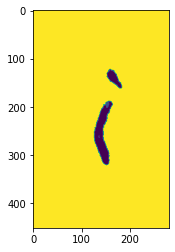

(451, 281)


In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import shutil
from pathlib import Path
import os


for f in glob.glob('base_data/train/**', recursive=True):
    if ".png" not in f:
        continue
    img = mpimg.imread(f)
    imgplot = plt.imshow(img)
    plt.show(block=True)
    print(img.shape)
    break


In [4]:
from PIL import Image
from PIL import ImageFont, ImageDraw
import os
import uuid
from random import randint

os.mkdir("font_based")
for c in class_names:
    os.mkdir(os.path.join("font_based", c))

def _generate(font, c, upper):
    image = Image.new("RGBA", (128,128), (255,255,255))
    usr_font = ImageFont.truetype(font, randint(40, 80))
    d_usr = ImageDraw.Draw(image)
    d_usr.fontmode = "1" # this apparently sets (anti)aliasing.  See link below.
    d_usr.text((randint(10, 40), randint(10, 40)), c.upper() if upper else c,(0,0,0), font=usr_font)
    image.save(os.path.join("font_based", c, f"{uuid.uuid1()}.png"))

def generate(font):
    for c in class_names:
        _generate(font, c, False)
        _generate(font, c, True)

        
font_root = "../fonts-main/ofl"
for font in os.listdir(font_root):
    if randint(1, 10) > 1:
        continue
    for f in os.listdir(font_root + "/" + font):
        if f.endswith(".ttf"):
            generate(os.path.join(font_root, font, f))

In [35]:
import uuid
str(uuid.uuid1())

'b0945b92-0638-11ec-b450-9b9d4b3c6bbe'

Base Data Validation Accuracy 0.6777
Cleaned nonsensical final loss 0.7061

+ Random Zoom 0.1, 0.6747
+ Random Shear 0.4 0.8198

Generated data only 0.5949

Shear + Generated 0.8464
 + Half generated 0.8548
 + quarter generated 0.8694

Train Found 1936 files belonging to 10 classes.
Font Found 4927 files belonging to 10 classes.
Valid Found 827 files belonging to 10 classes.


Validation data has no mis-scans that are offset by half the image.
- Allows extraneous lines on the page.
- Allows some hearts and smileys.

Flipping, cropping, random erasure are not viable techniques for MNIST because of the geometry of the characters.
However, shear, light rotation, and translation ARE viable techniques.

Random shears between -0.4 and 0.4 final loss 0.5460479259490967, final acc 0.8440145254135132
Shears + zoom final loss 0.6536434292793274, final acc 0.8536880016326904
0.823 w/ generated data.
final loss 0.9184684157371521, final acc 0.8162031173706055 with 0.25


GAN https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN